In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

In [3]:
import sys
sys.path.append('../../')

## Load data

In [4]:
def generate_combined_dfs(subjs, target_name):
    all_dfs = []
    for subj in subjs:
        df = pd.read_csv(f'data/pilot/behavior/{subj}.csv')
        all_dfs.append(df)
    combined = pd.concat(all_dfs, ignore_index=True)
    combined = combined.reset_index(drop=True)
    combined.to_csv(f'data/pilot/behavior/{target_name}.csv')
    
# generate_combined_dfs(subjs=[916, 917, 918, 920, 921, 922], target_name='916to922')

In [5]:
def load_behav_data(fpaths):
    dfs = []
    for fpath in fpaths:
        df = pd.read_csv(fpath)
        # drop any unnamed ?
        df = df.loc[:, ~df.columns.str.startswith('Unnamed')]
        dfs.append(df)
    loaded = pd.concat(dfs)
    loaded = loaded.reset_index(drop=True)
    
    return loaded

In [6]:
behavioral_df = load_behav_data([
    # f'data/pilot/behavior/902to905.csv', # debating if we should include them...
    f'data/pilot/behavior/908to915.csv',
    f'data/pilot/behavior/916to922.csv',
])
behavioral_df.head()

,participant,mode,sample_stage,stim_sample_method,block,trial,trial_code,ITI,stim_1,stim_region_1,...,resp_1_last_drawing_t,resp_1_last_drawing_curv,err_1,resp_2,resp_2_n_attempts,resp_2_last_drawing_tstart,resp_2_last_drawing_tend,resp_2_last_drawing_t,resp_2_last_drawing_curv,err_2
0,908,draw,0,mixed,0,0,0,1.466436,53.768502,1.0,...,1.033227,0.787746,0.231498,NaN,0,NaN,NaN,NaN,NaN,NaN
1,908,draw,0,mixed,0,1,0,2.577546,95.392638,2.0,...,2.533496,0.984970,11.607362,148.0,1,6.895704,9.128985,2.233281,1.119698,2.773095
2,908,draw,0,mixed,0,2,0,1.757377,169.828842,3.0,...,3.783250,16.073253,-6.828842,NaN,0,NaN,NaN,NaN,NaN,NaN
3,908,draw,0,mixed,0,3,0,1.932901,59.178761,1.0,...,1.533133,0.505287,-6.178761,35.0,1,7.544835,9.711595,2.166760,1.252607,-1.973983
4,908,draw,0,mixed,0,4,0,1.512830,114.967475,2.0,...,NaN,NaN,NaN,169.0,1,1.995037,6.494834,4.499797,0.984687,-4.183743


In [7]:
behavioral_df.columns

Index(['participant', 'mode', 'sample_stage', 'stim_sample_method', 'block',
       'trial', 'trial_code', 'ITI', 'stim_1', 'stim_region_1',
       'stim_1_to_report', 'stim_2', 'stim_region_2', 'stim_2_to_report',
       'delay', 'delay_post_stim', 'TRIALID', 'display_region', 'RT', 'resp_1',
       'resp_1_n_attempts', 'resp_1_last_drawing_tstart',
       'resp_1_last_drawing_tend', 'resp_1_last_drawing_t',
       'resp_1_last_drawing_curv', 'err_1', 'resp_2', 'resp_2_n_attempts',
       'resp_2_last_drawing_tstart', 'resp_2_last_drawing_tend',
       'resp_2_last_drawing_t', 'resp_2_last_drawing_curv', 'err_2'],
      dtype='object')

## Remove problematic participants

### TODO: retrieve the list of exclusion from experiment record

In [7]:
subjects_to_exclude = [908,] # slightly different setup...debating if we should separate them

### exclude participants whose accuracy do not pass the check

In [8]:
qc_summary_path = '../dual_ori_exp/real_data/eyetrack_pilot_data/QC/qc_summary.csv'
qc_loaded = pd.read_csv(qc_summary_path)
subjects_qc_fail = qc_loaded[qc_loaded['err < 30']<0.6]['participant'].to_list()
subjects_to_exclude += subjects_qc_fail

In [9]:
subjects_to_exclude

[908]

In [10]:
behavioral_df = behavioral_df[~behavioral_df['participant'].isin(subjects_to_exclude)]

In [11]:
behavioral_df.participant.unique()

array([909, 910, 912, 913, 914, 915, 916, 917, 918, 920, 921, 922])

## Reorganize data

In [12]:
from mydata_analysis.dual_ori_exp.utils.preprocess import (
    align_onset, compute_prior, error_detection, reorganize_data)

def reorganize_loaded_data(raw_df, err_thresh=None, to_align_onset=True):
    # error filtering
    if err_thresh is not None:
        prior = compute_prior(raw_df)
        err_mask = error_detection(raw_df, min_threshold=err_thresh, prior=prior)
        super_df = raw_df[~err_mask]
    else:
        super_df = raw_df

    # align onset of two responses
    if to_align_onset:
        super_df = align_onset(super_df)
    
    reorganized = reorganize_data(super_df)
    return reorganized

In [13]:
reorganized = reorganize_loaded_data(behavioral_df)

In [14]:
reorganized.head()

,participant,mode,sample_stage,stim_sample_method,block,trial,trial_code,ITI,delay,delay_post_stim,...,resp_last_drawing_curv,err,stim_id,order_code,neighbor_stim,neighbor_resp,pre_stim_early,pre_stim,pre_resp_early,pre_resp
0,909,click,0,mixed,0,1,0,1.365122,4.0,1.5,...,NaN,-19.271671,0.0,1,18.057948,25.0,NaN,86.255314,NaN,74.0
1,909,click,0,mixed,0,4,0,1.308832,4.0,1.5,...,NaN,-3.397791,0.0,1,155.176055,151.0,NaN,86.984914,NaN,63.0
2,909,click,0,mixed,0,5,0,2.729386,4.0,1.5,...,NaN,-0.656718,0.0,1,87.192484,85.0,153.397791,155.176055,150.0,151.0
3,909,click,0,mixed,0,6,0,1.526707,4.0,1.5,...,NaN,-13.595868,0.0,1,43.451788,43.0,39.656718,87.192484,39.0,85.0
4,909,click,0,mixed,1,3,0,2.287605,4.0,1.5,...,NaN,-5.278627,1.0,1,45.491761,58.0,NaN,73.233461,NaN,73.0


### For comparison: also load the preliminary data

In [15]:
from mydata_analysis.dual_ori_exp.utils.preprocess import load_and_clean_data

preliminary_cleaned_paths = [
    '../dual_ori_exp/real_data/cleaned_mode_compare_24jan_all/',
    '../dual_ori_exp/real_data/cleaned_aug_24/',
]
preliminary_df = load_and_clean_data(preliminary_cleaned_paths, err_thresh=None, to_align_onset=True)
preliminary_reorganized_df = reorganize_data(preliminary_df)

## Plot all biases

In [16]:
from mydata_analysis.dual_ori_exp.utils.plotting import smart_diff
from mydata_analysis.dual_ori_exp.utils.experiment import plot_binned_impact, get_binned_impact_data

PLOT_SAMPLE_WIDTH = 6
PLOT_BIN_WIDTH = 10

# copy from the original comparison notebook
def plot_curves(ax, xs, ys, 
        max_y, min_n_points,
        n_flip, always_pos, label,
        stat_type, stat_plot_type):
    # for cardinal, we still want to separate 0-45 and 45-90
    plot_n_flip = n_flip
    if n_flip == 2:
        plot_n_flip = 1
    
    # plot data
    if stat_plot_type == 'mean':
        binned_data = plot_binned_impact(
            ax, xs, ys, 
            max_y, min_n_points,
            plot_n_flip, always_pos, label,
            bin_width=PLOT_BIN_WIDTH, sample_width=PLOT_SAMPLE_WIDTH)
    elif stat_plot_type == 'sd':
        binned_data = get_binned_impact_data(
            xs, ys, 
            max_y, min_n_points,
            plot_n_flip, always_pos,
            bin_width=PLOT_BIN_WIDTH//2, sample_width=PLOT_SAMPLE_WIDTH)
        ys_sd = [np.sqrt(np.var(y)) for y in binned_data['y']]
        ax.plot(binned_data['x'], ys_sd, label=label)
    else:
        raise NotImplementedError(f'Unknown stat plot type {stat_plot_type}')
    return binned_data

In [17]:
def plot_bias_curve(ax, df, mask_lambda, x1, x2, y1, y2, label=None):
    mask = mask_lambda(df)
    df = df[mask]
    xs = smart_diff(df[x1], df[x2])
    ys = smart_diff(df[y1], df[y2])
    binned_data = plot_curves(
        ax, xs, ys, max_y=45, min_n_points=3,
        n_flip=1, always_pos=False, label=label,
        stat_type='bias', stat_plot_type='mean')
    
    y_lim = [-12, 12]
    ax.set_ylim(y_lim)
    y_label_text = 'error'
    ax.set_ylabel(y_label_text)
    ax.set_xlim([0, 90])
    ax.axvline(0, color='y', linestyle='--')
    ax.axhline(0, color='y', linestyle='--')
    
    return binned_data

## specify conditions to compare 

In [18]:
from collections import OrderedDict

all_conditions_to_compare = OrderedDict()

all_conditions_to_compare['compare different modes'] = OrderedDict([
    (
        'all',
        {
            'draw': lambda d: ((d['mode']=='draw') & (d['trial_code'].isin([0, 1]))).to_numpy(),
            'click': lambda d: ((d['mode']=='click') & (d['trial_code'].isin([0, 1]))).to_numpy(),
        }
    ), 
])

all_conditions_to_compare['when know what to report'] = OrderedDict([
    (
        'report 1 v.s. 1st response (draw)',
        {
            '1 to report': lambda d: ((d['mode']=='draw') & (d['trial_code']==0) & (d['order_code']==0)).to_numpy(),
            '1st of 2 to report': lambda d: ((d['mode']=='draw') & (d['trial_code']==0) & (d['order_code']==1)).to_numpy(),
        }
    ), 
    (
        'report 1 v.s. 2nd response (draw)',
        {
            '1 to report': lambda d: ((d['mode']=='draw') & (d['trial_code']==0) & (d['order_code']==0)).to_numpy(),
            '2nd of 2 to report': lambda d: ((d['mode']=='draw') & (d['trial_code']==0) & (d['order_code']==2)).to_numpy(),
        }
    ), 
    (
        'report 1 v.s. 1st response (click)',
        {
            '1 to report': lambda d: ((d['mode']=='click') & (d['trial_code']==0) & (d['order_code']==0)).to_numpy(),
            '1st of 2 to report': lambda d: ((d['mode']=='click') & (d['trial_code']==0) & (d['order_code']==1)).to_numpy(),
        }
    ), 
    (
        'report 1 v.s. 2nd response (click)',
        {
            '1 to report': lambda d: ((d['mode']=='click') & (d['trial_code']==0) & (d['order_code']==0)).to_numpy(),
            '2nd of 2 to report': lambda d: ((d['mode']=='click') & (d['trial_code']==0) & (d['order_code']==2)).to_numpy(),
        }
    ), 
])

all_conditions_to_compare['when both are to be reported'] = OrderedDict([
    (
        '1st response (draw)',
        {
            'know': lambda d: ((d['mode']=='draw') & (d['trial_code']==0) & (d['order_code']==1)).to_numpy(),
            'unknow': lambda d: ((d['mode']=='draw') & (d['trial_code']==1) & (d['order_code']==1)).to_numpy(),
        }
    ), 
    (
        '2nd response (draw)',
        {
            'know': lambda d: ((d['mode']=='draw') & (d['trial_code']==0) & (d['order_code']==2)).to_numpy(),
            'unknow': lambda d: ((d['mode']=='draw') & (d['trial_code']==1) & (d['order_code']==2)).to_numpy(),
        }
    ), 
    (
        '1st response (click)',
        {
            'know': lambda d: ((d['mode']=='click') & (d['trial_code']==0) & (d['order_code']==1)).to_numpy(),
            'unknow': lambda d: ((d['mode']=='click') & (d['trial_code']==1) & (d['order_code']==1)).to_numpy(),
        }
    ), 
    (
        '2nd response (click)',
        {
            'know': lambda d: ((d['mode']=='click') & (d['trial_code']==0) & (d['order_code']==2)).to_numpy(),
            'unknow': lambda d: ((d['mode']=='click') & (d['trial_code']==1) & (d['order_code']==2)).to_numpy(),
        }
    ), 
])

all_conditions_to_compare['when unknow what to report'] = OrderedDict([
    (
        'report 1 v.s. 1st response (draw)',
        {
            '1 to report': lambda d: ((d['mode']=='draw') & (d['trial_code']==1) & (d['order_code']==0)).to_numpy(),
            '1st of 2 to report': lambda d: ((d['mode']=='draw') & (d['trial_code']==1) & (d['order_code']==1)).to_numpy(),
        }
    ), 
    (
        'report 1 v.s. 2nd response (draw)',
        {
            '1 to report': lambda d: ((d['mode']=='draw') & (d['trial_code']==1) & (d['order_code']==0)).to_numpy(),
            '2nd of 2 to report': lambda d: ((d['mode']=='draw') & (d['trial_code']==1) & (d['order_code']==2)).to_numpy(),
        }
    ), 
    (
        'report 1 v.s. 1st response (click)',
        {
            '1 to report': lambda d: ((d['mode']=='click') & (d['trial_code']==1) & (d['order_code']==0)).to_numpy(),
            '1st of 2 to report': lambda d: ((d['mode']=='click') & (d['trial_code']==1) & (d['order_code']==1)).to_numpy(),
        }
    ), 
    (
        'report 1 v.s. 2nd response (click)',
        {
            '1 to report': lambda d: ((d['mode']=='click') & (d['trial_code']==1) & (d['order_code']==0)).to_numpy(),
            '2nd of 2 to report': lambda d: ((d['mode']=='click') & (d['trial_code']==1) & (d['order_code']==2)).to_numpy(),
        }
    ), 
])

all_conditions_to_compare['compare 1st and 2nd response'] = OrderedDict([
    (
        'draw, cue',
        {
            '1st': lambda d: ((d['mode']=='draw') & (d['trial_code']==0) & (d['order_code']==1)).to_numpy(),
            '2nd': lambda d: ((d['mode']=='draw') & (d['trial_code']==0) & (d['order_code']==2)).to_numpy(),
        }
    ), 
    (
        'draw, null cue',
        {
            '1st': lambda d: ((d['mode']=='draw') & (d['trial_code']==1) & (d['order_code']==1)).to_numpy(),
            '2nd': lambda d: ((d['mode']=='draw') & (d['trial_code']==1) & (d['order_code']==2)).to_numpy(),
        }
    ), 
    (
        'click, cue',
        {
            '1st': lambda d: ((d['mode']=='click') & (d['trial_code']==0) & (d['order_code']==1)).to_numpy(),
            '2nd': lambda d: ((d['mode']=='click') & (d['trial_code']==0) & (d['order_code']==2)).to_numpy(),
        }
    ), 
    (
        'click, null cue',
        {
            '1st': lambda d: ((d['mode']=='click') & (d['trial_code']==1) & (d['order_code']==1)).to_numpy(),
            '2nd': lambda d: ((d['mode']=='click') & (d['trial_code']==1) & (d['order_code']==2)).to_numpy(),
        }
    ), 
])

### Serial bias

In [19]:
def plot_serial(ax, df, mask_lambda, label=None):
    binned = plot_bias_curve(ax, df, mask_lambda, 'pre_resp', 'stim', 'resp', 'stim', label=label)
    x_label = f'last r - current s'
    ax.set_xlabel(x_label)
    return binned

In [20]:
def compare_serial_bias(df, masks_list, sup_title):
    nc = len(masks_list)
    fig, axs = plt.subplots(1, nc, figsize=(4*nc, 3))
    for i, title in enumerate(list(masks_list.keys())):
        ax = axs[i] if nc > 1 else axs
        masks = masks_list[title]
        n_data = {}
        for label, mask in masks.items():
            processed = plot_serial(ax, df, mask, label=label)
            n_data[label] = processed['n_total']
        ax.set_title(title)
        ax.legend(bbox_to_anchor=[1.0, 0.8], loc='center')
        # print(f'{title} -- {n_data}')
        
    plt.suptitle(sup_title)
    plt.tight_layout()

In [21]:
def compare_serial_bias_all_conditions(df, all_mask_lists):
    for analysis_name, analysis_masks in all_mask_lists.items():
        compare_serial_bias(df, analysis_masks, analysis_name)

#### Run all analysis on current batch

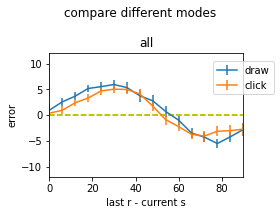

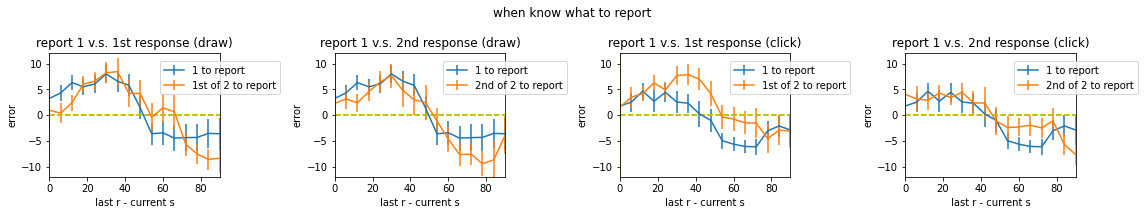

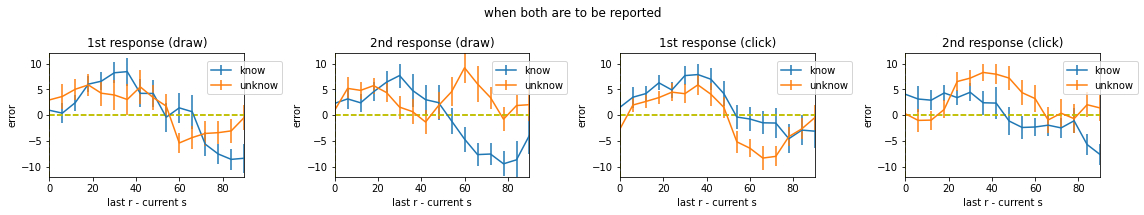

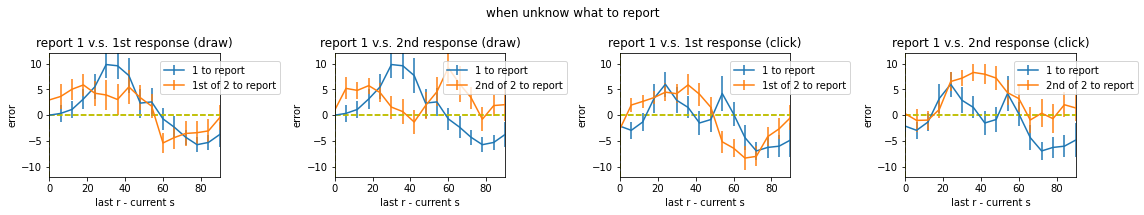

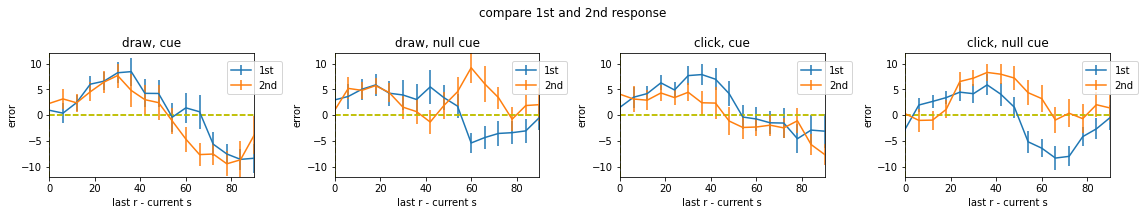

In [22]:
compare_serial_bias_all_conditions(reorganized, all_conditions_to_compare)

#### Run all analysis on preliminary data

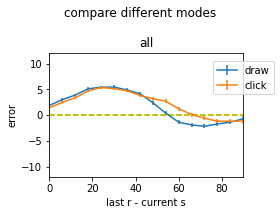

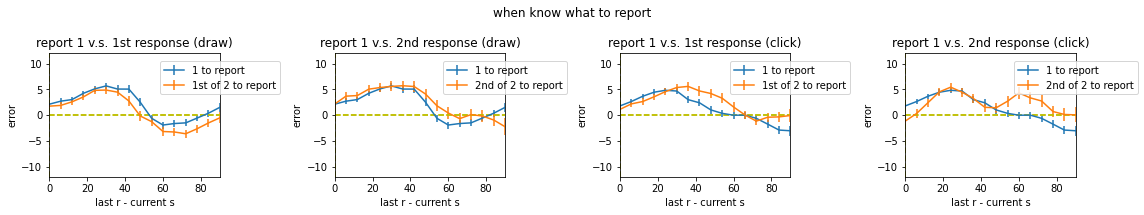

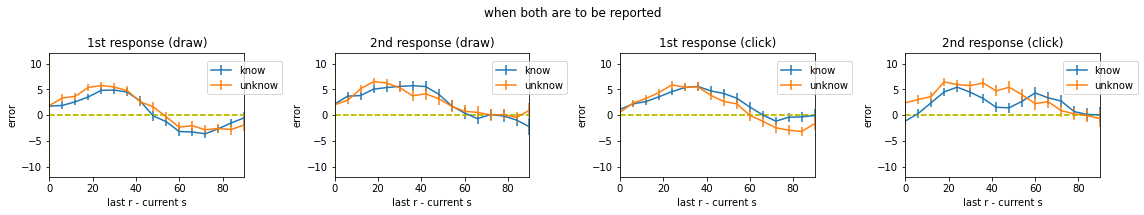

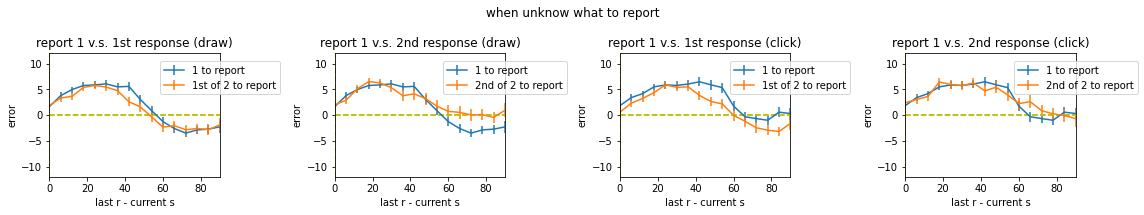

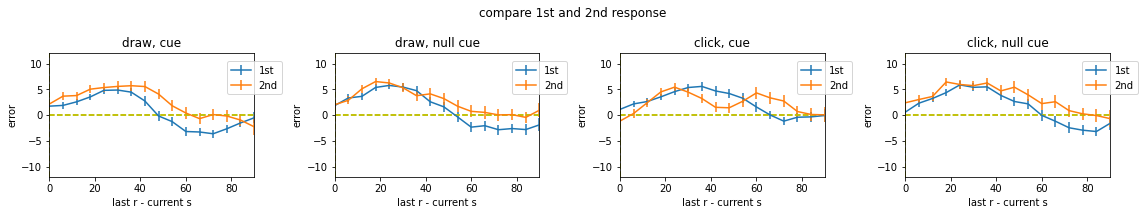

In [23]:
compare_serial_bias_all_conditions(preliminary_reorganized_df, all_conditions_to_compare)

### Surrounding bias

In [24]:
def plot_surrounding(ax, df, mask_lambda, label=None):
    binned = plot_bias_curve(ax, df, mask_lambda, 'neighbor_stim', 'stim', 'resp', 'stim', label=label)
    x_label = f'neighbor s - target s'
    ax.set_xlabel(x_label)
    return binned

In [25]:
def compare_surrounding_bias(df, masks_list, sup_title):
    nc = len(masks_list)
    fig, axs = plt.subplots(1, nc, figsize=(4*nc, 3))
    for i, title in enumerate(list(masks_list.keys())):
        ax = axs[i] if nc > 1 else axs
        masks = masks_list[title]
        n_data = {}
        for label, mask in masks.items():
            processed = plot_surrounding(ax, df, mask, label=label)
            n_data[label] = processed['n_total']
        ax.set_title(title)
        ax.legend(bbox_to_anchor=[1.0, 0.8], loc='center')
        # print(f'{title} -- {n_data}')
        
    plt.suptitle(sup_title)
    plt.tight_layout()

In [26]:
def compare_surrounding_bias_all_conditions(df, all_mask_lists):
    for analysis_name, analysis_masks in all_mask_lists.items():
        compare_surrounding_bias(df, analysis_masks, analysis_name)

#### Run all analysis on current batch

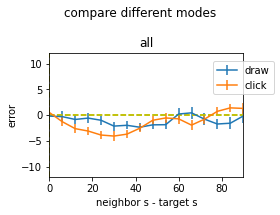

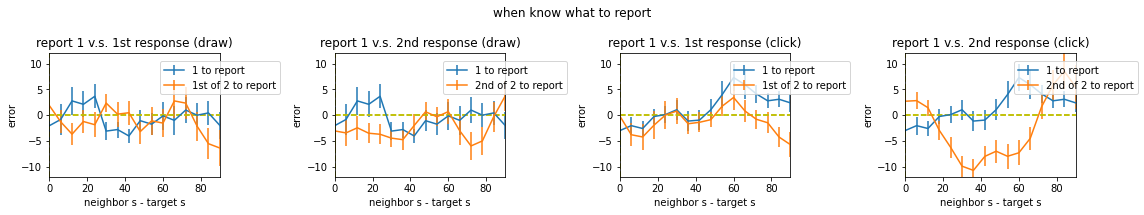

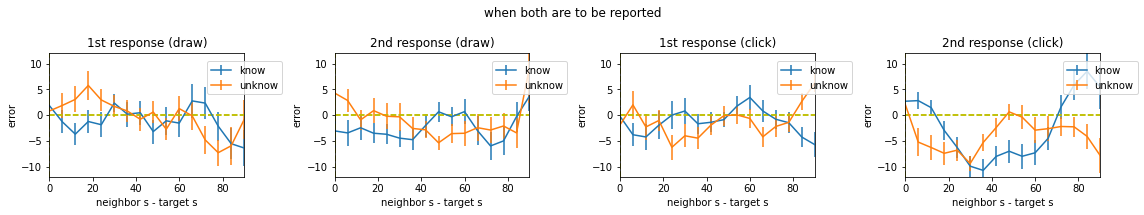

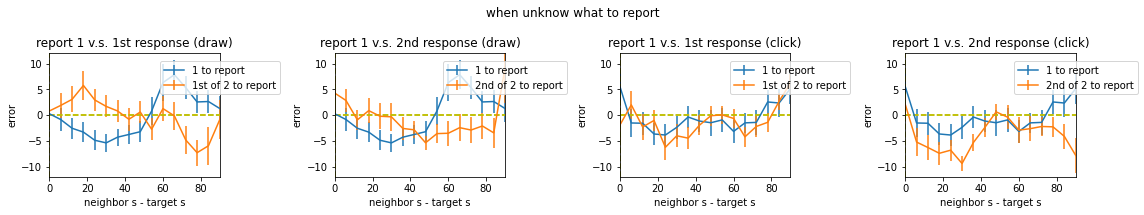

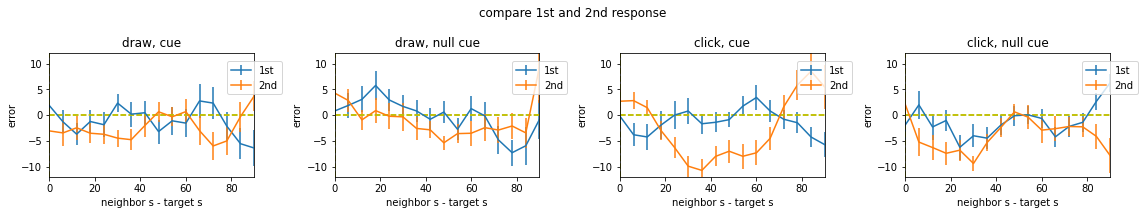

In [27]:
compare_surrounding_bias_all_conditions(reorganized, all_conditions_to_compare)

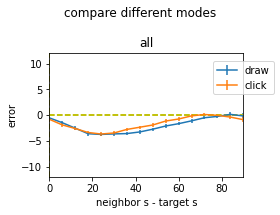

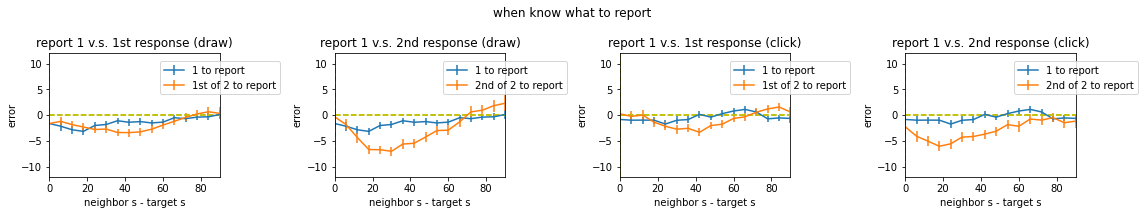

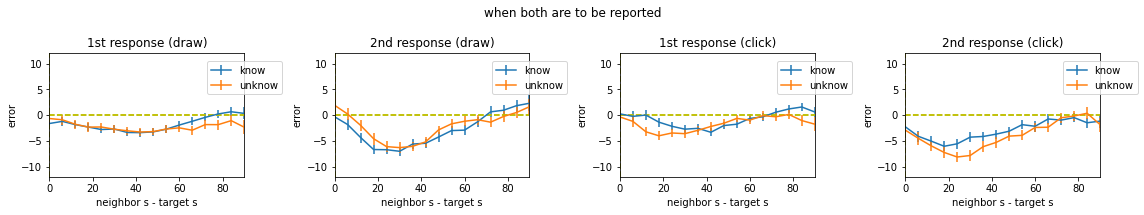

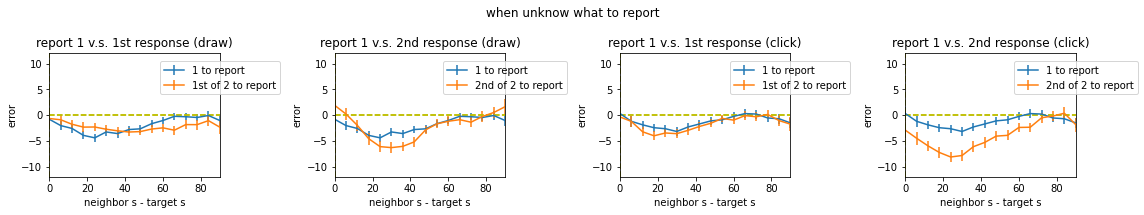

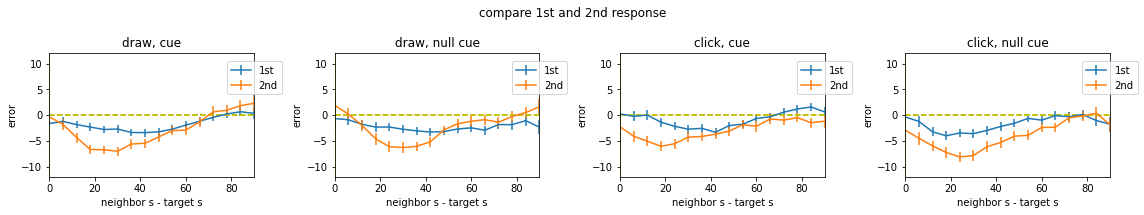

In [28]:
compare_surrounding_bias_all_conditions(preliminary_reorganized_df, all_conditions_to_compare)

## Incorporate the Survey result

In [29]:
from mydata_analysis.dual_ori_exp.utils.survey import preprocess_survey

survey_csv = pd.read_csv('data/survey.csv')
survey_csv = preprocess_survey(survey_csv)

In [30]:
eyetracking_pilot_subjects = reorganized['participant'].unique()
eyetracking_survey = survey_csv.loc[eyetracking_pilot_subjects]

In [31]:
preliminary_subjects = preliminary_reorganized_df['participant'].unique()
valid_preliminary_indices = survey_csv.index.intersection(preliminary_subjects)
preliminary_survey = survey_csv.loc[valid_preliminary_indices]

### First check distribution of strategy

In [32]:
def plot_one_question(ax, df, qname, label_map, xmax=12):
    # label map: mapping numeric label to text
    labels, counts = np.unique(df[qname], return_counts=True)
    counts = {k:v for k,v in zip(labels, counts)}
    labels_sorted = [label for label in label_map.keys()] # if label in labels
    counts_sorted = [
        counts.get(label, 0) for label in labels_sorted]
    captions = [label_map[label] for label in labels_sorted]
    ax.barh(captions, counts_sorted, color='skyblue')
    for i, count in enumerate(counts_sorted):
        ax.text(count+0.8*xmax/10, i, str(count), va='center', ha='right')
    ax.set_yticks(np.arange(len(captions)))
    ax.set_yticklabels(captions)
    ax.invert_yaxis()
    if xmax is not None:
        ax.set_xlim([0, xmax])
    ax.set_xticks([])

In [33]:
def plot_strategy_questions(survey_data, xmax=22):
    questions = OrderedDict([
        ('Q1.2', 'draw, null cue'),
        ('Q1.3', 'draw, informatic cue'),
        ('Q1.4', 'click, null cue'),
        ('Q1.5', 'click, informatic cue'),
    ])

    fig, axs = plt.subplots(1, len(questions), figsize=(4*len(questions), 3))
    for plot_id, qname in enumerate(list(questions.keys())):
        label_map = OrderedDict([
            (1, 'pictorial'), 
            (2, 'abstract'), 
            (3, 'action'), 
            (4, 'mixed'), 
            (5, 'other'),
        ])
        plot_one_question(axs[plot_id], survey_data, qname, label_map, xmax=xmax)
        axs[plot_id].set_title(questions[qname])
    plt.tight_layout()

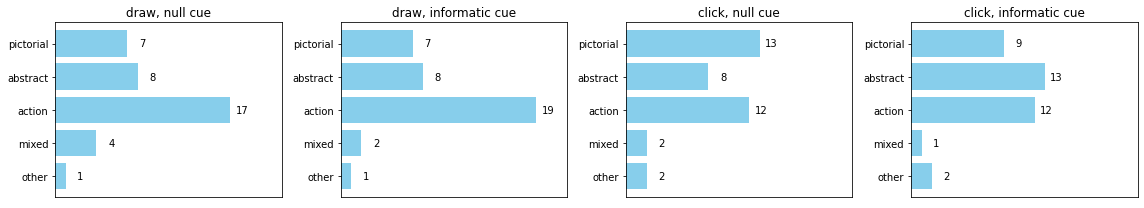

In [34]:
plot_strategy_questions(preliminary_survey, xmax=22)

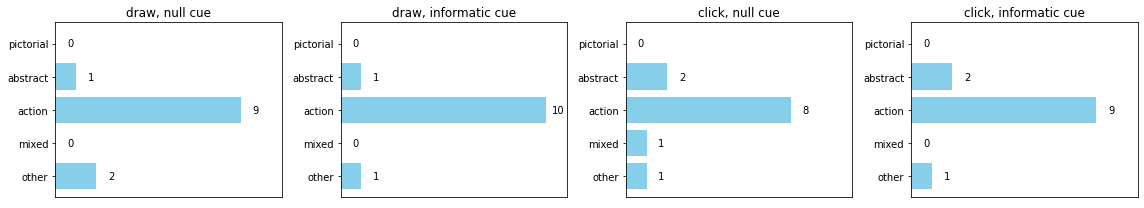

In [37]:
plot_strategy_questions(eyetracking_survey, xmax=11)

In [36]:
eyetracking_pilot_subjects

array([909, 910, 912, 913, 914, 915, 916, 917, 918, 920, 921, 922])

<b>comment</b> after we change the setting, difference in strategies reported disappear...

### Also bias as function of strategies